In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

num_classes = len(id_map.keys())

In [3]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

def prepare_tensor_dataset(train_path, val_path):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    for file in tqdm(os.listdir(train_path)):
        img, mask = preprocess(f"{train_path}/{file}")
        X_train.append(img)
        Y_train.append(mask)
    
    for file in tqdm(os.listdir(val_path)):
        img, mask = preprocess(f"{val_path}/{file}")
        X_val.append(img)
        Y_val.append(mask)

    return X_train, Y_train, X_val, Y_val

In [5]:
X_train, Y_train, X_valid, Y_valid = prepare_tensor_dataset("./cityscapes_data/train/",
                                                            "./cityscapes_data/val/")

100%|██████████| 500/500 [15:08<00:00,  1.82s/it]


In [6]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

In [15]:
np.save('X_train.npy', X_train) 
np.save('Y_train.npy', Y_train) 
np.save('X_valid.npy', X_valid) 
np.save('Y_valid.npy', Y_valid) 

In [7]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection
    
    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)
    
    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection
    
    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)
    
    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection
    
    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)
    
    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)
    
    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [8]:
model = get_unet_model()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-26 12:53:35.701424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-26 12:53:35.703064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
tf.keras.utils.plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [13]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [11]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights = True)
viz_callback = VizCallback("./cityscapes_data/val/106.jpg")

Epoch 1/100


2023-03-26 12:54:11.195110: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-26 12:54:11.843813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


93/93 [==============================] - ETA: 0s - loss: 1.1597 - accuracy: 0.6859 - mean_iou: 0.1290

2023-03-26 12:59:47.281787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-26 13:00:10.095672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 890ms/step


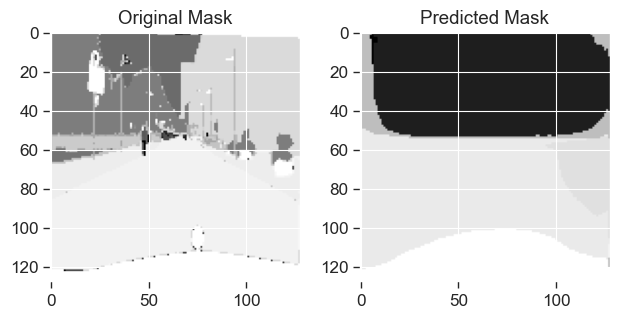

93/93 [==============================] - 360s 4s/step - loss: 1.1597 - accuracy: 0.6859 - mean_iou: 0.1290 - val_loss: 2.5274 - val_accuracy: 0.4704 - val_mean_iou: 0.0538
Epoch 2/100
1/1 [==============================] - 0s 290ms/steposs: 0.8653 - accuracy: 0.7653 - mean_iou: 0.19


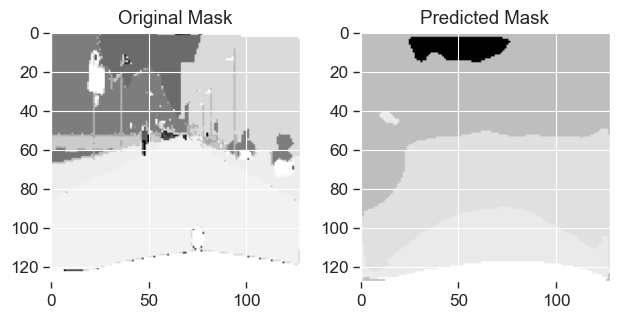

93/93 [==============================] - 441s 5s/step - loss: 0.8653 - accuracy: 0.7653 - mean_iou: 0.1929 - val_loss: 2.0523 - val_accuracy: 0.3912 - val_mean_iou: 0.0560
Epoch 3/100
1/1 [==============================] - 0s 67ms/steploss: 0.7844 - accuracy: 0.7880 - mean_iou: 0.21


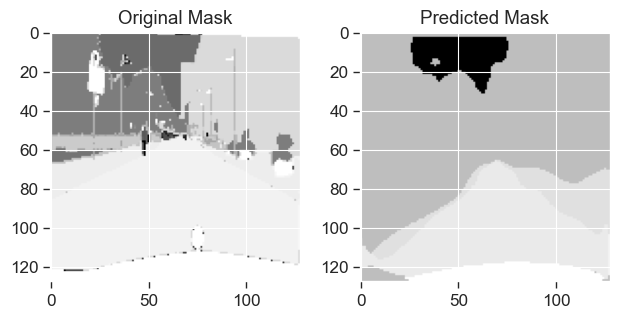

93/93 [==============================] - 409s 4s/step - loss: 0.7844 - accuracy: 0.7880 - mean_iou: 0.2139 - val_loss: 2.2399 - val_accuracy: 0.4364 - val_mean_iou: 0.0659
Epoch 4/100
1/1 [==============================] - 0s 57ms/steploss: 0.7229 - accuracy: 0.8033 - mean_iou: 0.23


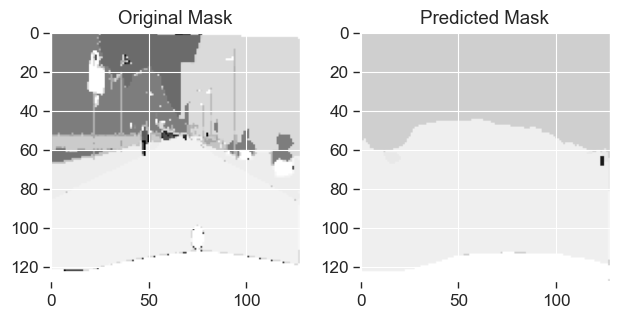

93/93 [==============================] - 391s 4s/step - loss: 0.7229 - accuracy: 0.8033 - mean_iou: 0.2316 - val_loss: 2.1382 - val_accuracy: 0.5631 - val_mean_iou: 0.0652
Epoch 5/100
1/1 [==============================] - 0s 55ms/steploss: 0.6847 - accuracy: 0.8127 - mean_iou: 0.24


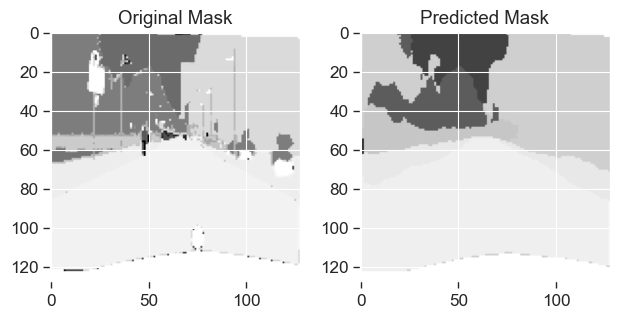

93/93 [==============================] - 376s 4s/step - loss: 0.6847 - accuracy: 0.8127 - mean_iou: 0.2445 - val_loss: 1.2862 - val_accuracy: 0.6612 - val_mean_iou: 0.1254
Epoch 6/100
1/1 [==============================] - 0s 46ms/steploss: 0.6507 - accuracy: 0.8202 - mean_iou: 0.25


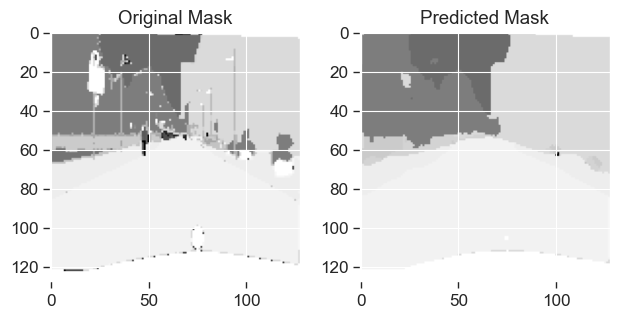

93/93 [==============================] - 353s 4s/step - loss: 0.6507 - accuracy: 0.8202 - mean_iou: 0.2583 - val_loss: 0.8968 - val_accuracy: 0.7718 - val_mean_iou: 0.1988
Epoch 7/100
1/1 [==============================] - 0s 55ms/steploss: 0.6270 - accuracy: 0.8253 - mean_iou: 0.26


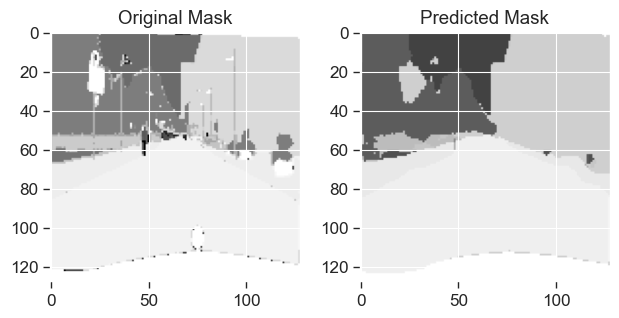

93/93 [==============================] - 331s 4s/step - loss: 0.6270 - accuracy: 0.8253 - mean_iou: 0.2694 - val_loss: 1.0005 - val_accuracy: 0.7576 - val_mean_iou: 0.1932
Epoch 8/100
1/1 [==============================] - 0s 50ms/steploss: 0.6126 - accuracy: 0.8281 - mean_iou: 0.28


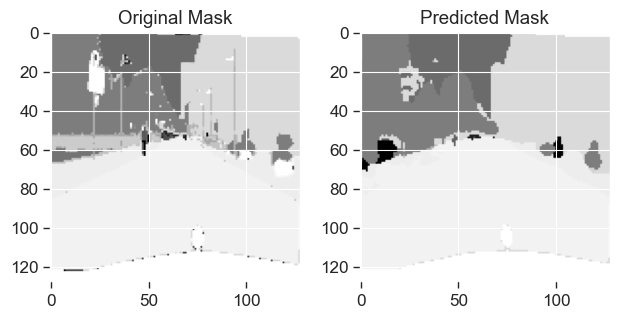

93/93 [==============================] - 318s 3s/step - loss: 0.6126 - accuracy: 0.8281 - mean_iou: 0.2800 - val_loss: 0.7697 - val_accuracy: 0.8008 - val_mean_iou: 0.2353
Epoch 9/100
1/1 [==============================] - 0s 63ms/steploss: 0.5914 - accuracy: 0.8336 - mean_iou: 0.29


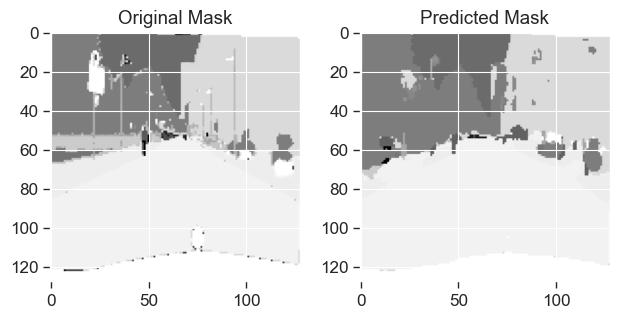

93/93 [==============================] - 331s 4s/step - loss: 0.5914 - accuracy: 0.8336 - mean_iou: 0.2943 - val_loss: 0.8875 - val_accuracy: 0.7569 - val_mean_iou: 0.2183
Epoch 10/100
1/1 [==============================] - 0s 74ms/steploss: 0.5691 - accuracy: 0.8392 - mean_iou: 0.30


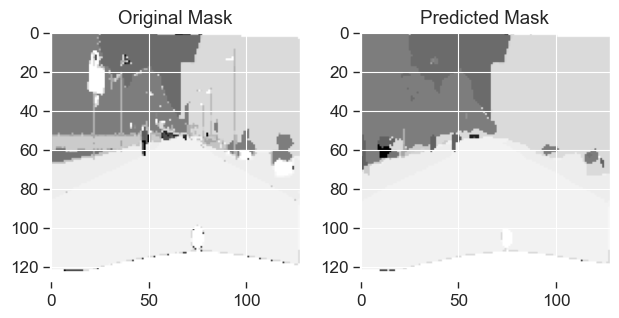

93/93 [==============================] - 323s 3s/step - loss: 0.5691 - accuracy: 0.8392 - mean_iou: 0.3055 - val_loss: 0.6865 - val_accuracy: 0.8094 - val_mean_iou: 0.2625
Epoch 11/100
1/1 [==============================] - 0s 103ms/steposs: 0.5524 - accuracy: 0.8427 - mean_iou: 0.32


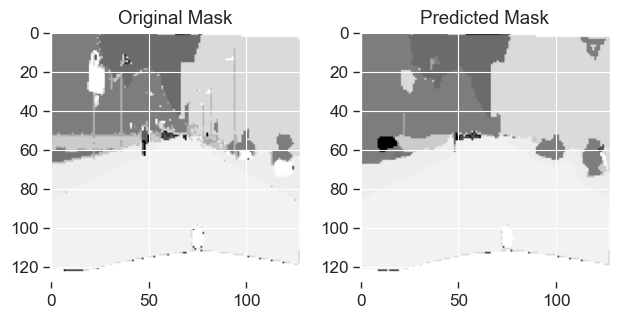

93/93 [==============================] - 302s 3s/step - loss: 0.5524 - accuracy: 0.8427 - mean_iou: 0.3211 - val_loss: 0.7271 - val_accuracy: 0.8082 - val_mean_iou: 0.2522
Epoch 12/100
1/1 [==============================] - 0s 52ms/steploss: 0.5422 - accuracy: 0.8450 - mean_iou: 0.32


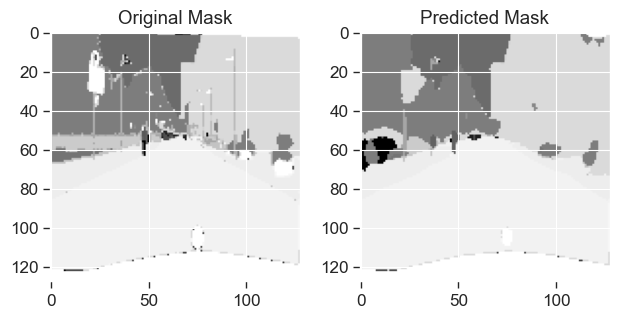

93/93 [==============================] - 296s 3s/step - loss: 0.5422 - accuracy: 0.8450 - mean_iou: 0.3238 - val_loss: 0.6578 - val_accuracy: 0.8144 - val_mean_iou: 0.2716
Epoch 13/100
1/1 [==============================] - 0s 58ms/steploss: 0.5317 - accuracy: 0.8481 - mean_iou: 0.33


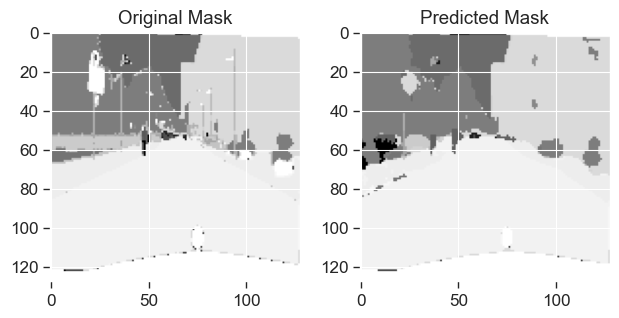

93/93 [==============================] - 306s 3s/step - loss: 0.5317 - accuracy: 0.8481 - mean_iou: 0.3375 - val_loss: 0.6618 - val_accuracy: 0.8151 - val_mean_iou: 0.2781
Epoch 14/100
1/1 [==============================] - 0s 48ms/steploss: 0.5163 - accuracy: 0.8524 - mean_iou: 0.34


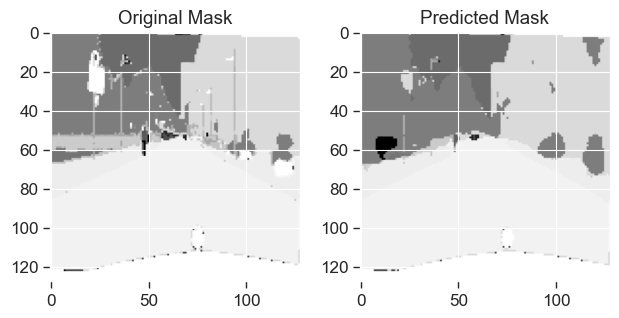

93/93 [==============================] - 331s 4s/step - loss: 0.5163 - accuracy: 0.8524 - mean_iou: 0.3429 - val_loss: 0.6518 - val_accuracy: 0.8194 - val_mean_iou: 0.2875
Epoch 15/100
1/1 [==============================] - 0s 66ms/steploss: 0.5050 - accuracy: 0.8548 - mean_iou: 0.35


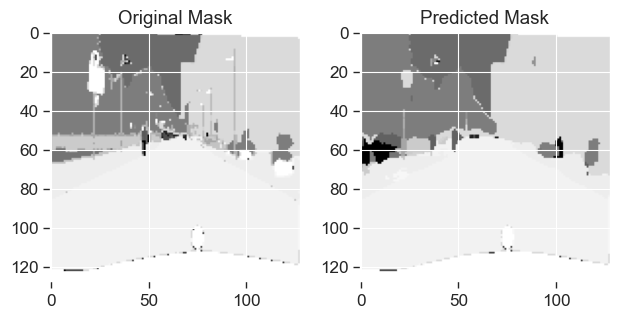

93/93 [==============================] - 347s 4s/step - loss: 0.5050 - accuracy: 0.8548 - mean_iou: 0.3584 - val_loss: 0.6841 - val_accuracy: 0.8005 - val_mean_iou: 0.2767
Epoch 16/100
1/1 [==============================] - 0s 61ms/steploss: 0.4987 - accuracy: 0.8568 - mean_iou: 0.36


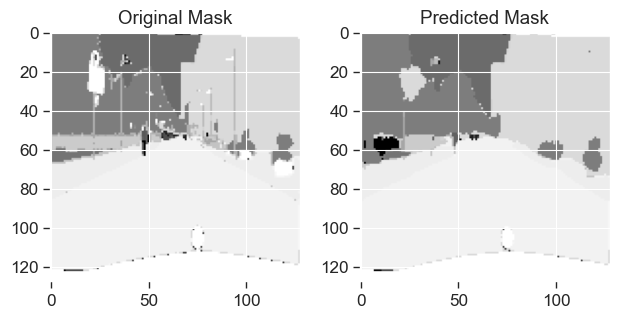

93/93 [==============================] - 411s 4s/step - loss: 0.4987 - accuracy: 0.8568 - mean_iou: 0.3612 - val_loss: 0.6385 - val_accuracy: 0.8274 - val_mean_iou: 0.2917
Epoch 17/100
1/1 [==============================] - 0s 55ms/steploss: 0.4818 - accuracy: 0.8614 - mean_iou: 0.37


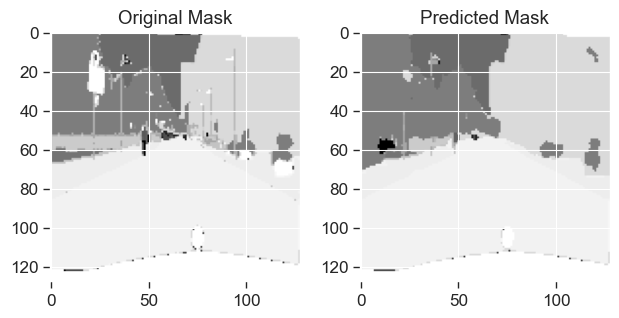

93/93 [==============================] - 365s 4s/step - loss: 0.4818 - accuracy: 0.8614 - mean_iou: 0.3748 - val_loss: 0.6515 - val_accuracy: 0.8139 - val_mean_iou: 0.2922
Epoch 18/100
1/1 [==============================] - 0s 77ms/steploss: 0.4756 - accuracy: 0.8635 - mean_iou: 0.38


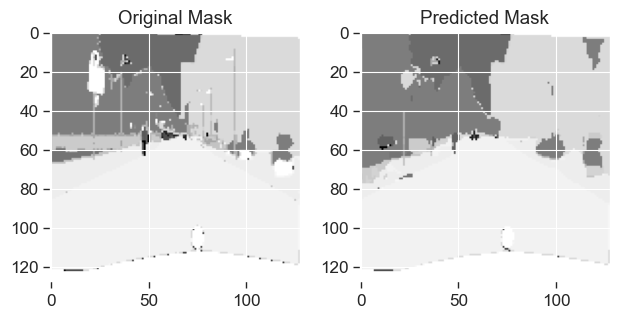

93/93 [==============================] - 315s 3s/step - loss: 0.4756 - accuracy: 0.8635 - mean_iou: 0.3822 - val_loss: 0.7052 - val_accuracy: 0.8213 - val_mean_iou: 0.2888
Epoch 19/100
1/1 [==============================] - 0s 47ms/steploss: 0.4654 - accuracy: 0.8659 - mean_iou: 0.38


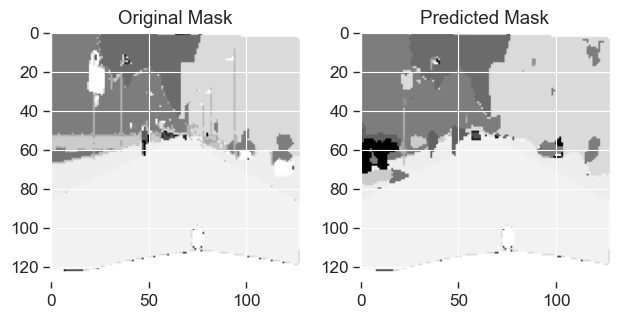

93/93 [==============================] - 311s 3s/step - loss: 0.4654 - accuracy: 0.8659 - mean_iou: 0.3885 - val_loss: 0.6515 - val_accuracy: 0.8213 - val_mean_iou: 0.2939
Epoch 20/100
1/1 [==============================] - 0s 48ms/steploss: 0.4573 - accuracy: 0.8678 - mean_iou: 0.39


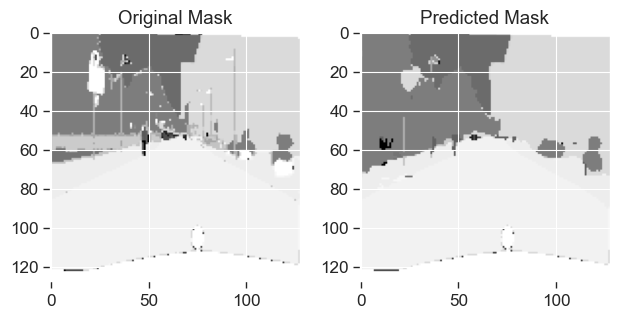

93/93 [==============================] - 301s 3s/step - loss: 0.4573 - accuracy: 0.8678 - mean_iou: 0.3974 - val_loss: 0.6250 - val_accuracy: 0.8267 - val_mean_iou: 0.3003
Epoch 21/100
1/1 [==============================] - 0s 54ms/steploss: 0.4558 - accuracy: 0.8688 - mean_iou: 0.39


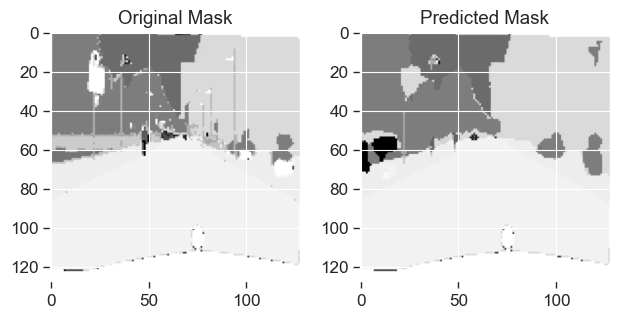

93/93 [==============================] - 294s 3s/step - loss: 0.4558 - accuracy: 0.8688 - mean_iou: 0.3993 - val_loss: 0.6662 - val_accuracy: 0.8216 - val_mean_iou: 0.3040
Epoch 22/100
1/1 [==============================] - 0s 57ms/steploss: 0.4410 - accuracy: 0.8724 - mean_iou: 0.41


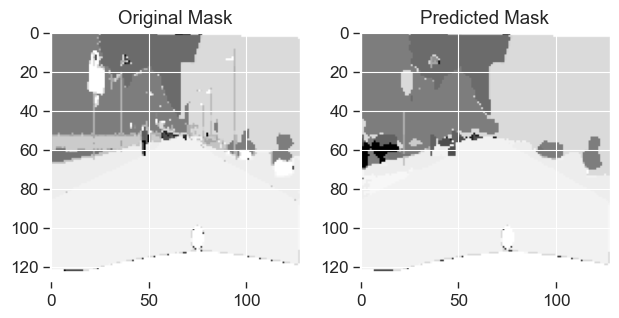

93/93 [==============================] - 297s 3s/step - loss: 0.4410 - accuracy: 0.8724 - mean_iou: 0.4138 - val_loss: 0.6413 - val_accuracy: 0.8322 - val_mean_iou: 0.2965
Epoch 23/100
1/1 [==============================] - 0s 46ms/steploss: 0.4309 - accuracy: 0.8753 - mean_iou: 0.42


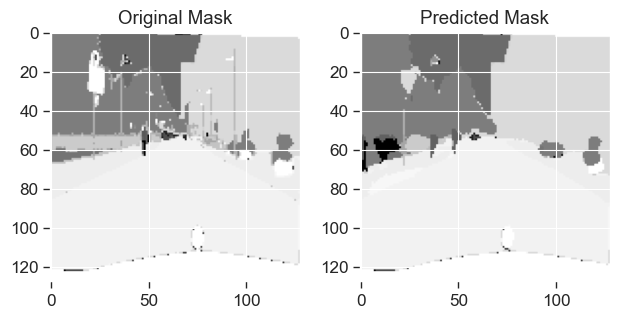

93/93 [==============================] - 300s 3s/step - loss: 0.4309 - accuracy: 0.8753 - mean_iou: 0.4235 - val_loss: 0.6342 - val_accuracy: 0.8328 - val_mean_iou: 0.3148
Epoch 24/100
1/1 [==============================] - 0s 48ms/steploss: 0.4169 - accuracy: 0.8789 - mean_iou: 0.43


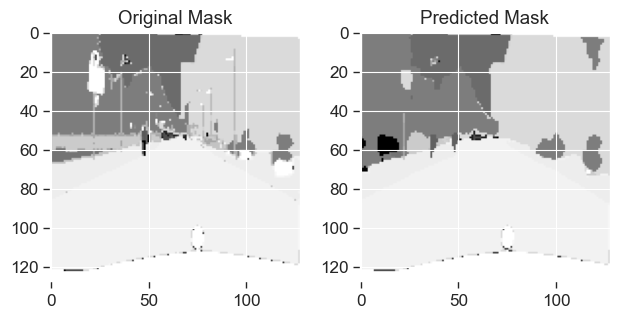

93/93 [==============================] - 302s 3s/step - loss: 0.4169 - accuracy: 0.8789 - mean_iou: 0.4321 - val_loss: 0.6345 - val_accuracy: 0.8328 - val_mean_iou: 0.3063
Epoch 25/100
1/1 [==============================] - 0s 64ms/steploss: 0.4238 - accuracy: 0.8771 - mean_iou: 0.42


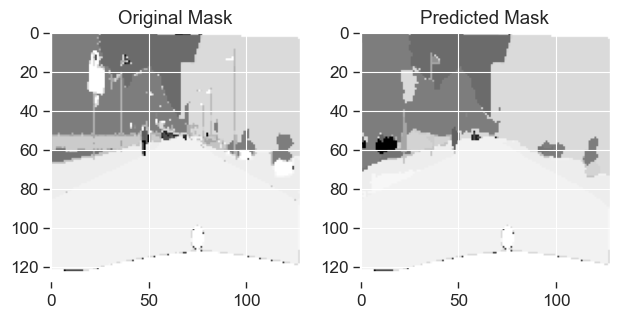

93/93 [==============================] - 321s 3s/step - loss: 0.4238 - accuracy: 0.8771 - mean_iou: 0.4260 - val_loss: 0.6964 - val_accuracy: 0.8123 - val_mean_iou: 0.3005
Epoch 26/100
1/1 [==============================] - 0s 105ms/steposs: 0.4106 - accuracy: 0.8805 - mean_iou: 0.43


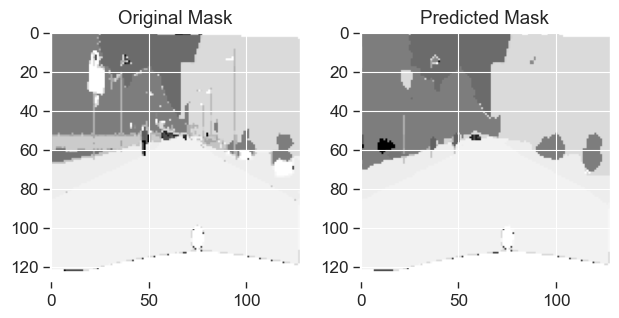

93/93 [==============================] - 337s 4s/step - loss: 0.4106 - accuracy: 0.8805 - mean_iou: 0.4369 - val_loss: 0.6848 - val_accuracy: 0.8163 - val_mean_iou: 0.3011
Epoch 27/100
1/1 [==============================] - 0s 47ms/steploss: 0.4039 - accuracy: 0.8826 - mean_iou: 0.44


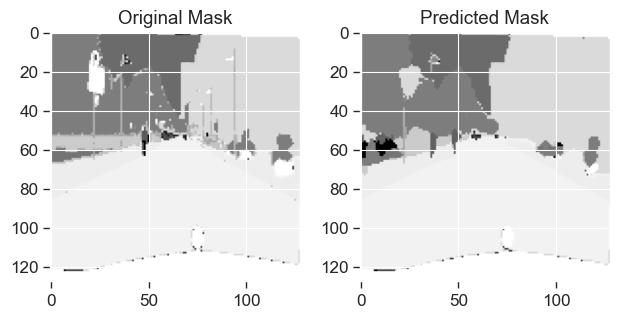

93/93 [==============================] - 321s 3s/step - loss: 0.4039 - accuracy: 0.8826 - mean_iou: 0.4462 - val_loss: 0.6407 - val_accuracy: 0.8358 - val_mean_iou: 0.3221
Epoch 28/100
1/1 [==============================] - 0s 55ms/steploss: 0.4026 - accuracy: 0.8825 - mean_iou: 0.44


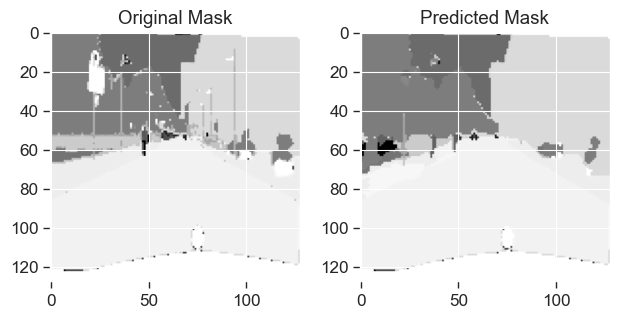

93/93 [==============================] - 341s 4s/step - loss: 0.4026 - accuracy: 0.8825 - mean_iou: 0.4495 - val_loss: 0.6449 - val_accuracy: 0.8270 - val_mean_iou: 0.3121
Epoch 29/100
1/1 [==============================] - 0s 49ms/steploss: 0.3926 - accuracy: 0.8855 - mean_iou: 0.45


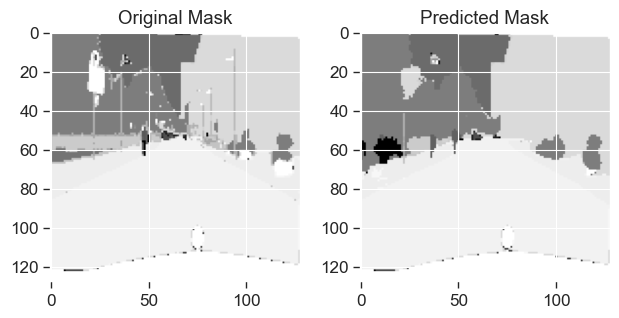

93/93 [==============================] - 301s 3s/step - loss: 0.3926 - accuracy: 0.8855 - mean_iou: 0.4591 - val_loss: 0.6062 - val_accuracy: 0.8365 - val_mean_iou: 0.3318
Epoch 30/100
1/1 [==============================] - 0s 52ms/steploss: 0.3745 - accuracy: 0.8908 - mean_iou: 0.47


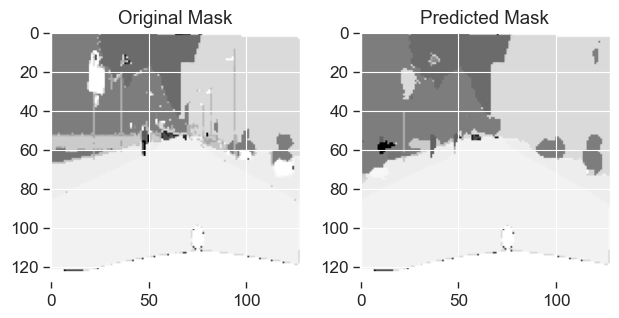

93/93 [==============================] - 599s 6s/step - loss: 0.3745 - accuracy: 0.8908 - mean_iou: 0.4763 - val_loss: 0.6444 - val_accuracy: 0.8379 - val_mean_iou: 0.3242
Epoch 31/100
1/1 [==============================] - 0s 47ms/steploss: 0.3727 - accuracy: 0.8910 - mean_iou: 0.48


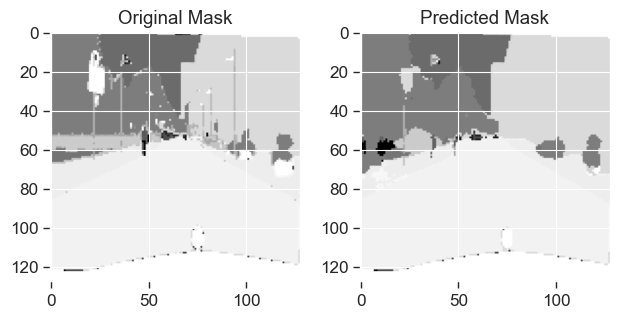

93/93 [==============================] - 307s 3s/step - loss: 0.3727 - accuracy: 0.8910 - mean_iou: 0.4814 - val_loss: 0.6313 - val_accuracy: 0.8394 - val_mean_iou: 0.3347
Epoch 32/100
1/1 [==============================] - 0s 61ms/steploss: 0.3590 - accuracy: 0.8948 - mean_iou: 0.490


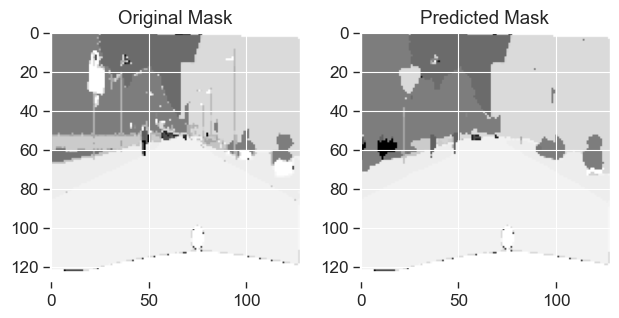

93/93 [==============================] - 965s 10s/step - loss: 0.3590 - accuracy: 0.8948 - mean_iou: 0.4908 - val_loss: 0.6453 - val_accuracy: 0.8378 - val_mean_iou: 0.3251
Epoch 33/100
1/1 [==============================] - 0s 64ms/steploss: 0.3537 - accuracy: 0.8962 - mean_iou: 0.50


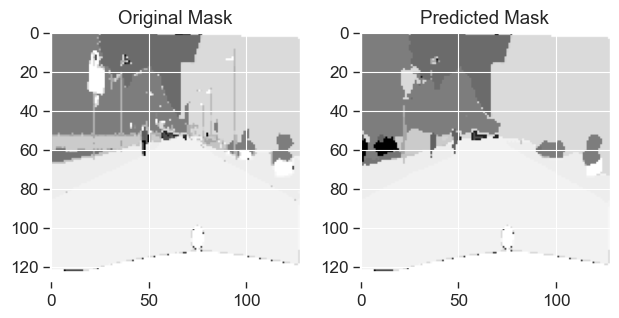

93/93 [==============================] - 324s 3s/step - loss: 0.3537 - accuracy: 0.8962 - mean_iou: 0.5011 - val_loss: 0.6629 - val_accuracy: 0.8369 - val_mean_iou: 0.3251
Epoch 34/100
1/1 [==============================] - 0s 49ms/steploss: 0.3493 - accuracy: 0.8975 - mean_iou: 0.50


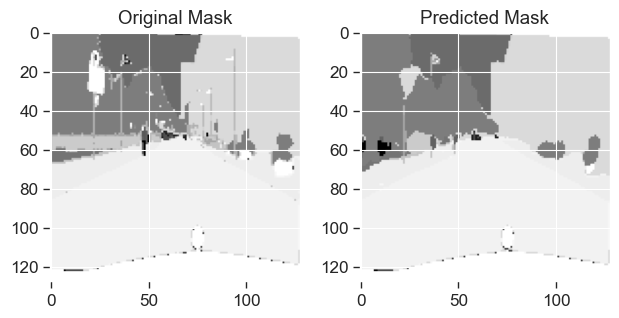

93/93 [==============================] - 287s 3s/step - loss: 0.3493 - accuracy: 0.8975 - mean_iou: 0.5073 - val_loss: 0.6444 - val_accuracy: 0.8392 - val_mean_iou: 0.3421
Epoch 35/100
1/1 [==============================] - 0s 50ms/steploss: 0.3388 - accuracy: 0.9005 - mean_iou: 0.51


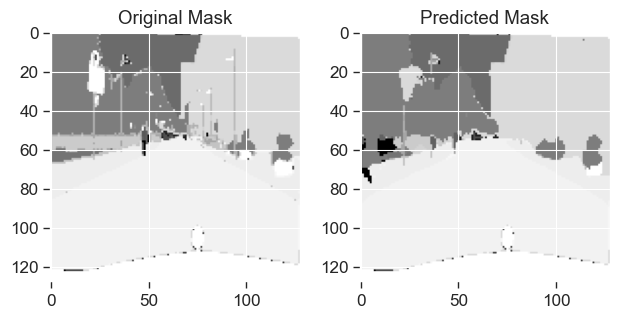

93/93 [==============================] - 286s 3s/step - loss: 0.3388 - accuracy: 0.9005 - mean_iou: 0.5179 - val_loss: 0.6593 - val_accuracy: 0.8407 - val_mean_iou: 0.3295
Epoch 36/100
1/1 [==============================] - 0s 53ms/steploss: 0.3453 - accuracy: 0.8984 - mean_iou: 0.51


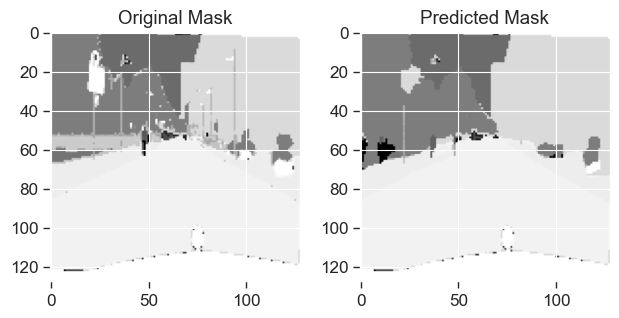

93/93 [==============================] - 302s 3s/step - loss: 0.3453 - accuracy: 0.8984 - mean_iou: 0.5117 - val_loss: 0.6828 - val_accuracy: 0.8416 - val_mean_iou: 0.3320
Epoch 37/100
1/1 [==============================] - 0s 52ms/steploss: 0.3380 - accuracy: 0.9002 - mean_iou: 0.52


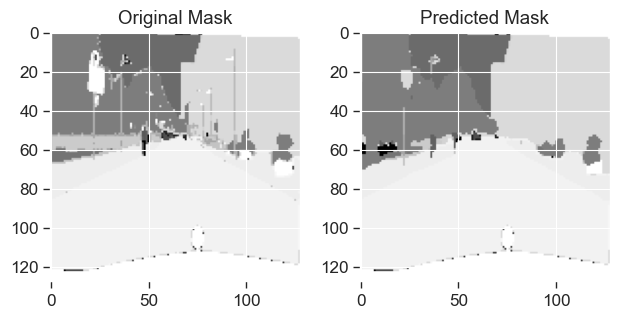

93/93 [==============================] - 309s 3s/step - loss: 0.3380 - accuracy: 0.9002 - mean_iou: 0.5202 - val_loss: 0.6967 - val_accuracy: 0.8366 - val_mean_iou: 0.3292
Epoch 38/100
1/1 [==============================] - 0s 53ms/steploss: 0.3338 - accuracy: 0.9015 - mean_iou: 0.52


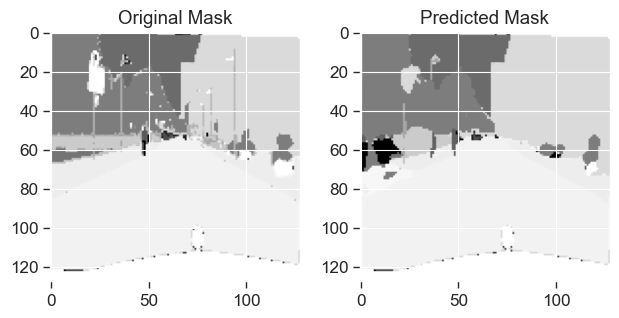

93/93 [==============================] - 302s 3s/step - loss: 0.3338 - accuracy: 0.9015 - mean_iou: 0.5271 - val_loss: 0.6853 - val_accuracy: 0.8337 - val_mean_iou: 0.3300
Epoch 39/100
1/1 [==============================] - 0s 51ms/steploss: 0.3262 - accuracy: 0.9034 - mean_iou: 0.53


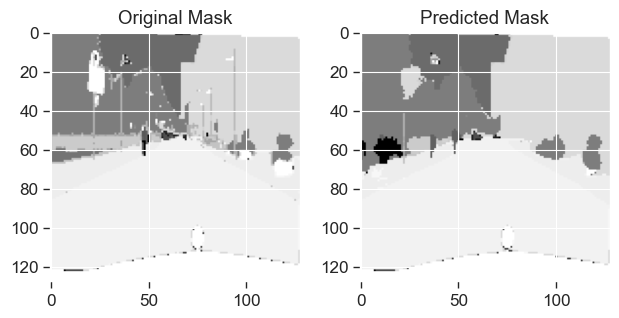

93/93 [==============================] - 298s 3s/step - loss: 0.3262 - accuracy: 0.9034 - mean_iou: 0.5335 - val_loss: 0.6701 - val_accuracy: 0.8382 - val_mean_iou: 0.3403


In [14]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid), callbacks=[early_stopping, viz_callback])

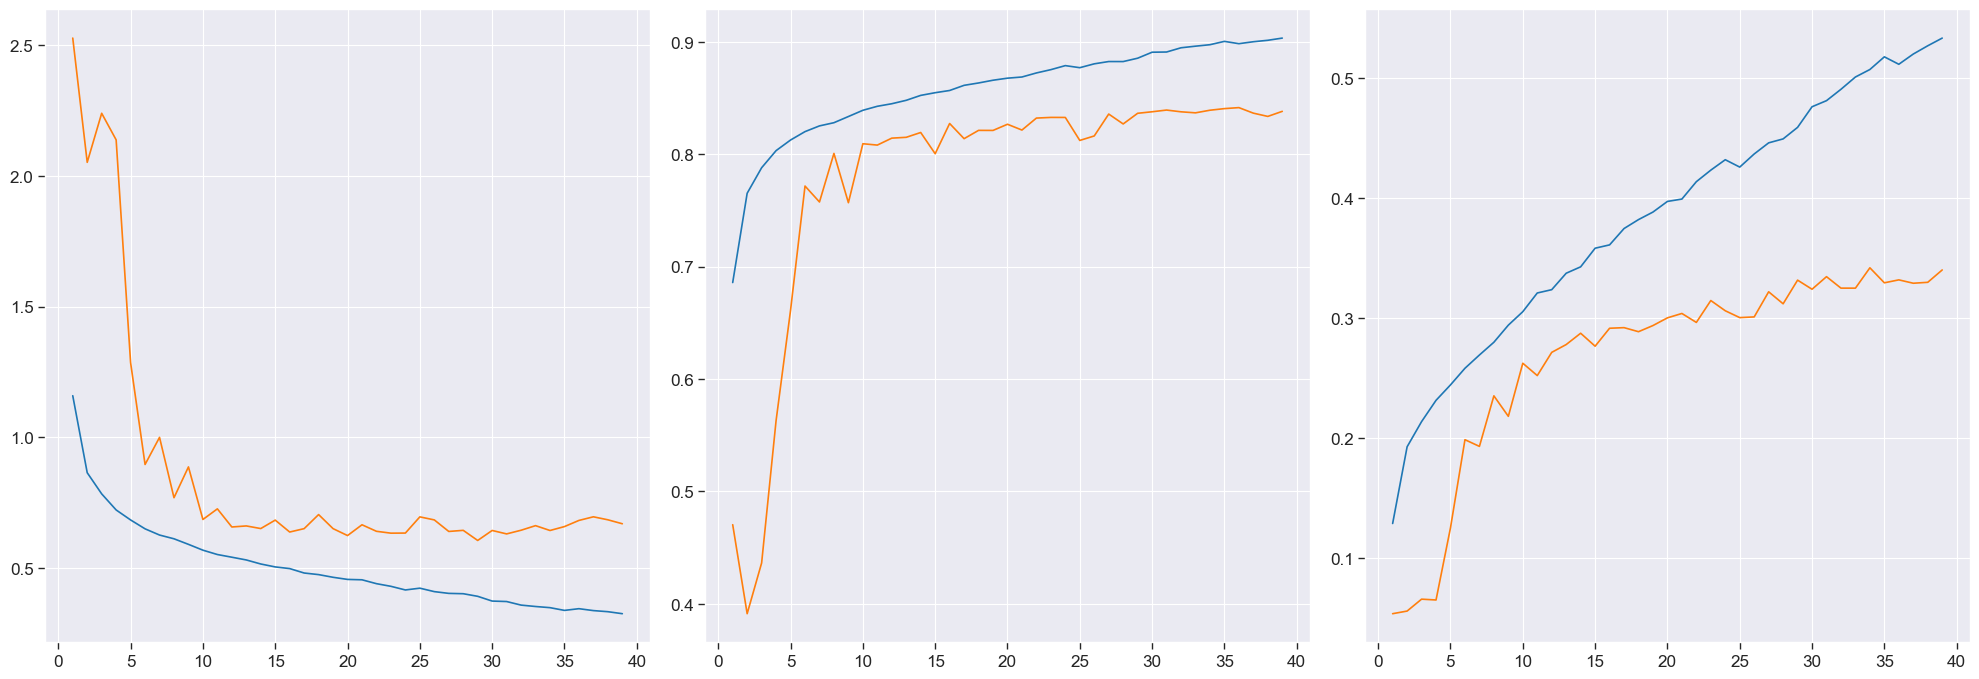

In [23]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
plt.subplot(131)
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["loss"])
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["val_loss"])
plt.subplot(132)
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["accuracy"])
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["val_accuracy"])
plt.subplot(133)
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["mean_iou"])
plt.plot(range(1, len(history.history["loss"]) + 1),history.history["val_mean_iou"])
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 39ms/step


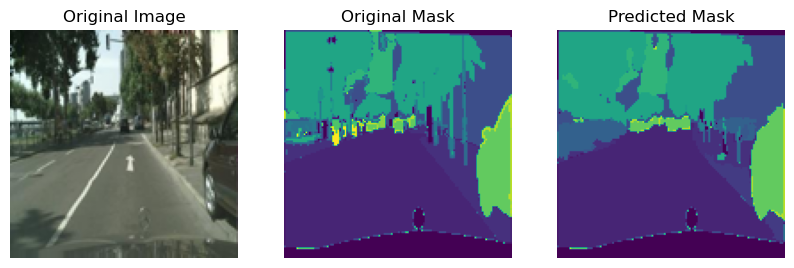

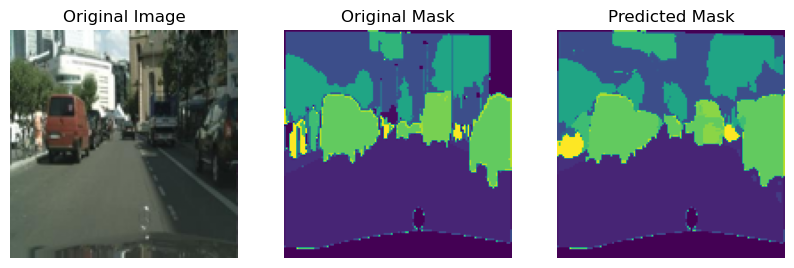

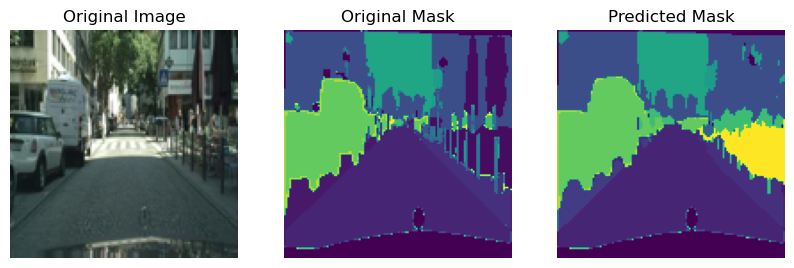

In [24]:
plt.style.use("default")
for i in os.listdir("./cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"./cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")